# Formate Beads Experiment Design - Integrated Model

This notebook contains a complete model for designing formate bead experiments with bacterial cultures. It integrates:
- **Bead release kinetics** (M07 and M03 beads)
- **Bacterial growth** (Monod kinetics)
- **Substrate consumption**
- **Constant substrate maintenance** (automated bead scheduling)

The model calculates how many beads to add each day to maintain constant substrate concentration despite bacterial consumption.

## 1. Import Required Libraries

Import all necessary libraries for numerical calculations, differential equations, and plotting.

In [201]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from typing import Dict, List, Optional

# Configure matplotlib for inline plotting
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

## 3. Process Bead Release Data

Apply correction for linear interpolation and validate against physical bead properties.

## 2. Experiment Configuration

**Configure all experimental parameters here.** All subsequent cells will use these values.

Modify this cell to run different scenarios:
- Update bead release profiles (empirical measurements)
- Adjust Monod kinetics parameters for your bacterial strain
- Change culture volume and target substrate concentration
- Set initial conditions and experiment duration

In [202]:
# ============================================================================
# EXPERIMENT CONFIGURATION - MODIFY PARAMETERS HERE
# ============================================================================

# ---- Formate Properties ----
FORMATE_MW = 68  # mg/mmol (molecular weight of formate)

# ---- Bead Physical Properties ----
M07_FORMATE_CONTENT = 50.252  # mg formate per M07 bead
M03_FORMATE_CONTENT = 35.1356  # mg formate per M03 bead

# ---- Empirical Bead Release Data (mmol/day) ----
# M07 beads: High initial release, decreasing over 7 days
M07_EMPIRICAL = {
    1: 0.444,  # Day 1: High release
    2: 0.135,
    3: 0.05,
    4: 0.04,
    5: 0.03,
    6: 0.02,
    7: 0.02   # Day 7: Low release
}

# M03 beads: More sustained release profile
M03_EMPIRICAL = {
    1: 0.279909614,   
    2: 0.085731303,
    3: 0.068230318,
    4: 0.033414337,
    5: 0.02,
    6: 0.02,
    7: 0.01
}

# ---- Culture Parameters ----
VOLUME = 0.3  # Culture volume (Liters)

# ---- Monod Kinetics Parameters ----
MONOD_PARAMS = {
    'mu_max': 1,        # Maximum growth rate (1/day)
    'K_s': 20.0,        # Half-saturation constant (mmol/L)
    'Y_xs': 0.0067      # Yield coefficient (OD per mmol/L substrate)
                        # Note: Lower than glucose (0.2) due to formate's lower energy content
}

# ---- Target Substrate Control ----
TARGET_CONCENTRATION = 30.0  # Target substrate concentration (mmol/L)
TOLERANCE = 0.1              # Acceptable deviation as fraction (0.1 = ±10%)

# ---- Initial Conditions ----
INITIAL_OD = 0.02            # Initial bacterial optical density
EXPERIMENT_DAYS = 5          # Total experiment duration (days)

# ---- Simulation Parameters ----
SIMULATION_DT = 0.01         # Time step for numerical integration (days)

# ============================================================================
# DISPLAY CONFIGURATION
# ============================================================================
print("=" * 70)
print("EXPERIMENT CONFIGURATION")
print("=" * 70)

print("\n📦 Bead Properties:")
print(f"  M07 formate content: {M07_FORMATE_CONTENT} mg/bead")
print(f"  M03 formate content: {M03_FORMATE_CONTENT} mg/bead")
print(f"  M07 total release: {sum(M07_EMPIRICAL.values()):.4f} mmol = {sum(M07_EMPIRICAL.values())*FORMATE_MW:.2f} mg")
print(f"  M03 total release: {sum(M03_EMPIRICAL.values()):.4f} mmol = {sum(M03_EMPIRICAL.values())*FORMATE_MW:.2f} mg")

print("\n🧫 Culture Parameters:")
print(f"  Volume: {VOLUME} L")
print(f"  Initial OD: {INITIAL_OD}")
print(f"  Duration: {EXPERIMENT_DAYS} days")

print("\n🦠 Monod Kinetics:")
print(f"  μ_max (max growth rate): {MONOD_PARAMS['mu_max']} 1/day")
print(f"  K_s (half-saturation): {MONOD_PARAMS['K_s']} mmol/L")
print(f"  Y_xs (yield coefficient): {MONOD_PARAMS['Y_xs']} OD per mmol/L")

print("\n🎯 Substrate Control:")
print(f"  Target concentration: {TARGET_CONCENTRATION} mmol/L")
print(f"  Tolerance: ±{TOLERANCE*100:.0f}% ({TARGET_CONCENTRATION*(1-TOLERANCE):.1f} - {TARGET_CONCENTRATION*(1+TOLERANCE):.1f} mmol/L)")

print("\n⚙️  Simulation:")
print(f"  Time step (dt): {SIMULATION_DT} days")

print("\n" + "=" * 70)
print("✓ Configuration loaded successfully!")
print("=" * 70)

EXPERIMENT CONFIGURATION

📦 Bead Properties:
  M07 formate content: 50.252 mg/bead
  M03 formate content: 35.1356 mg/bead
  M07 total release: 0.7390 mmol = 50.25 mg
  M03 total release: 0.5173 mmol = 35.18 mg

🧫 Culture Parameters:
  Volume: 0.3 L
  Initial OD: 0.02
  Duration: 5 days

🦠 Monod Kinetics:
  μ_max (max growth rate): 1 1/day
  K_s (half-saturation): 20.0 mmol/L
  Y_xs (yield coefficient): 0.0067 OD per mmol/L

🎯 Substrate Control:
  Target concentration: 30.0 mmol/L
  Tolerance: ±10% (27.0 - 33.0 mmol/L)

⚙️  Simulation:
  Time step (dt): 0.01 days

✓ Configuration loaded successfully!


In [203]:
# ============================================================================
# BEAD RELEASE PROFILE CORRECTION
# ============================================================================
# This cell processes the empirical bead release data from the configuration
# above and corrects it for linear interpolation to ensure that the integral
# of the interpolated curve matches the empirical total release.
# ============================================================================

def correct_for_linear_interpolation(empirical_profile):
    """
    Adjust release rates so that the integral of linear interpolation
    matches the discrete sum of empirical measurements.
    
    When we linearly interpolate between daily points, the integral
    (area under the curve) differs from the discrete sum. This function
    calculates a scaling factor to correct for this.
    
    Args:
        empirical_profile (dict): Measured daily release rates
        
    Returns:
        dict: Corrected release rates for use with linear interpolation
    """
    days = sorted(empirical_profile.keys())
    
    # Calculate what the integral WOULD BE with current values
    integral = 0.0
    for i in range(len(days) - 1):
        day1 = days[i]
        day2 = days[i + 1]
        rate1 = empirical_profile[day1]
        rate2 = empirical_profile[day2]
        # Trapezoidal area
        area = 0.5 * (rate1 + rate2) * (day2 - day1)
        integral += area
    
    # Add final day (triangle to zero)
    last_day = days[-1]
    last_rate = empirical_profile[last_day]
    integral += 0.5 * last_rate * 1
    
    # Calculate what the discrete sum IS
    discrete_sum = sum(empirical_profile.values())
    
    # Calculate scaling factor needed
    scaling_factor = discrete_sum / integral if integral > 0 else 1.0
    
    # Apply scaling to all rates
    corrected_profile = {day: rate * scaling_factor 
                        for day, rate in empirical_profile.items()}
    
    return corrected_profile, scaling_factor

# Apply correction to get profiles suitable for linear interpolation
M07_BEAD_RELEASE, m07_scale = correct_for_linear_interpolation(M07_EMPIRICAL)
M03_BEAD_RELEASE, m03_scale = correct_for_linear_interpolation(M03_EMPIRICAL)

print(f"✓ Release profiles corrected for linear interpolation")
print(f"  M07 scaling factor: {m07_scale:.4f} ({(m07_scale-1)*100:+.1f}%)")
print(f"  M03 scaling factor: {m03_scale:.4f} ({(m03_scale-1)*100:+.1f}%)")

# Validation checks
# Calculate empirical data sums and validate against configured bead capacity
m07_empirical_sum = sum(M07_EMPIRICAL.values())
m03_empirical_sum = sum(M03_EMPIRICAL.values())

# Convert to mg and validate against physical bead capacity
m07_total_mg = m07_empirical_sum * FORMATE_MW
m03_total_mg = m03_empirical_sum * FORMATE_MW

m07_percent_released = (m07_total_mg / M07_FORMATE_CONTENT) * 100
m03_percent_released = (m03_total_mg / M03_FORMATE_CONTENT) * 100

print("\n" + "=" * 60)
print("EMPIRICAL DATA VALIDATION")
print("=" * 60)
print(f"\nM07 Beads (Empirical):")
print(f"  Total release over 7 days: {m07_empirical_sum:.4f} mmol = {m07_total_mg:.2f} mg")
print(f"  Formate content per bead: {M07_FORMATE_CONTENT} mg")
print(f"  Percent released: {m07_percent_released:.1f}%")

print(f"\nM03 Beads (Empirical):")
print(f"  Total release over 7 days: {m03_empirical_sum:.4f} mmol = {m03_total_mg:.2f} mg")
print(f"  Formate content per bead: {M03_FORMATE_CONTENT} mg")
print(f"  Percent released: {m03_percent_released:.1f}%")

# Validate: Release should be within ±1% of bead capacity (tolerance for rounding)
CAPACITY_TOLERANCE_UPPER = 1.01  # Allow 1% over capacity
CAPACITY_TOLERANCE_LOWER = 0.99  # Allow 1% under capacity

# Check M07 beads
if m07_total_mg > M07_FORMATE_CONTENT * CAPACITY_TOLERANCE_UPPER:
    raise ValueError(f"❌ ERROR: M07 empirical release ({m07_total_mg:.2f} mg) exceeds "
                     f"configured bead capacity ({M07_FORMATE_CONTENT} mg) by more than 1%!\n"
                     f"Please check your M07_EMPIRICAL data or M07_FORMATE_CONTENT setting.")

if m07_total_mg < M07_FORMATE_CONTENT * CAPACITY_TOLERANCE_LOWER and m07_percent_released > 30:
    print(f"\n⚠️  Note: M07 release ({m07_total_mg:.2f} mg) is more than 1% below "
          f"bead capacity ({M07_FORMATE_CONTENT} mg).")
    print(f"   Difference: {M07_FORMATE_CONTENT - m07_total_mg:.2f} mg")

# Check M03 beads
if m03_total_mg > M03_FORMATE_CONTENT * CAPACITY_TOLERANCE_UPPER:
    raise ValueError(f"❌ ERROR: M03 empirical release ({m03_total_mg:.2f} mg) exceeds "
                     f"configured bead capacity ({M03_FORMATE_CONTENT} mg) by more than 1%!\n"
                     f"Please check your M03_EMPIRICAL data or M03_FORMATE_CONTENT setting.")

if m03_total_mg < M03_FORMATE_CONTENT * CAPACITY_TOLERANCE_LOWER and m03_percent_released > 30:
    print(f"\n⚠️  Note: M03 release ({m03_total_mg:.2f} mg) is more than 1% below "
          f"bead capacity ({M03_FORMATE_CONTENT} mg).")
    print(f"   Difference: {M03_FORMATE_CONTENT - m03_total_mg:.2f} mg")

# Warning if release is suspiciously low (< 30% of capacity)
if m07_percent_released < 30:
    print(f"\n⚠️  Note: M07 release is only {m07_percent_released:.1f}% of bead capacity.")
    print(f"   If this is unexpected, check your M07_EMPIRICAL data.")

if m03_percent_released < 30:
    print(f"\n⚠️  Note: M03 release is only {m03_percent_released:.1f}% of bead capacity.")
    print(f"   If this is unexpected, check your M03_EMPIRICAL data.")

print("\n✓ Validation passed: Empirical data within acceptable range of bead capacity (±1%)")

# Check 3: Validate interpolated linear release integral
# The integral of linear interpolation between daily points should equal the sum of daily releases
# For linear interpolation: integral = sum of trapezoidal areas
print("\n" + "=" * 60)
print("INTERPOLATION VALIDATION")
print("=" * 60)

def validate_interpolated_integral(release_profile, empirical_profile, bead_name):
    """
    Calculate the integral of the linearly interpolated release rate
    and verify it matches the empirical discrete sum.
    """
    days = sorted(release_profile.keys())
    
    # Calculate integral using trapezoidal rule
    integral = 0.0
    for i in range(len(days) - 1):
        day1 = days[i]
        day2 = days[i + 1]
        rate1 = release_profile[day1]
        rate2 = release_profile[day2]
        
        # Trapezoidal area for this segment
        area = 0.5 * (rate1 + rate2) * (day2 - day1)
        integral += area
    
    # Add the final day (triangle from last rate to 0)
    last_day = days[-1]
    last_rate = release_profile[last_day]
    integral += 0.5 * last_rate * 1
    
    # Compare with empirical discrete sum (the target)
    empirical_sum = sum(empirical_profile.values())
    
    # Calculate difference
    difference = abs(integral - empirical_sum)
    percent_error = (difference / empirical_sum) * 100 if empirical_sum > 0 else 0
    
    print(f"\n{bead_name} Beads:")
    print(f"  Empirical sum (target):      {empirical_sum:.4f} mmol")
    print(f"  Corrected rates sum:         {sum(release_profile.values()):.4f} mmol")
    print(f"  Interpolated integral:       {integral:.4f} mmol")
    print(f"  Error vs empirical:          {difference:.4f} mmol ({percent_error:.2f}%)")
    
    if percent_error < 0.1:
        print(f"  ✓ Excellent match! (error < 0.1%)")
    elif percent_error < 1.0:
        print(f"  ✓ Good match (error < 1%)")
    else:
        print(f"  ⚠ WARNING: Error exceeds 1%!")
    
    return integral, empirical_sum, difference

# Validate both bead types
m07_integral, m07_empirical, m07_diff = validate_interpolated_integral(
    M07_BEAD_RELEASE, M07_EMPIRICAL, "M07"
)
m03_integral, m03_empirical, m03_diff = validate_interpolated_integral(
    M03_BEAD_RELEASE, M03_EMPIRICAL, "M03"
)

print("\n" + "=" * 60)
print("✓ Interpolation validation complete!")
print("=" * 60)

✓ Release profiles corrected for linear interpolation
  M07 scaling factor: 1.4294 (+42.9%)
  M03 scaling factor: 1.3709 (+37.1%)

EMPIRICAL DATA VALIDATION

M07 Beads (Empirical):
  Total release over 7 days: 0.7390 mmol = 50.25 mg
  Formate content per bead: 50.252 mg
  Percent released: 100.0%

M03 Beads (Empirical):
  Total release over 7 days: 0.5173 mmol = 35.18 mg
  Formate content per bead: 35.1356 mg
  Percent released: 100.1%

✓ Validation passed: Empirical data within acceptable range of bead capacity (±1%)

INTERPOLATION VALIDATION

M07 Beads:
  Empirical sum (target):      0.7390 mmol
  Corrected rates sum:         1.0563 mmol
  Interpolated integral:       0.7390 mmol
  Error vs empirical:          0.0000 mmol (0.00%)
  ✓ Excellent match! (error < 0.1%)

M03 Beads:
  Empirical sum (target):      0.5173 mmol
  Corrected rates sum:         0.7092 mmol
  Interpolated integral:       0.5173 mmol
  Error vs empirical:          0.0000 mmol (0.00%)
  ✓ Excellent match! (error < 

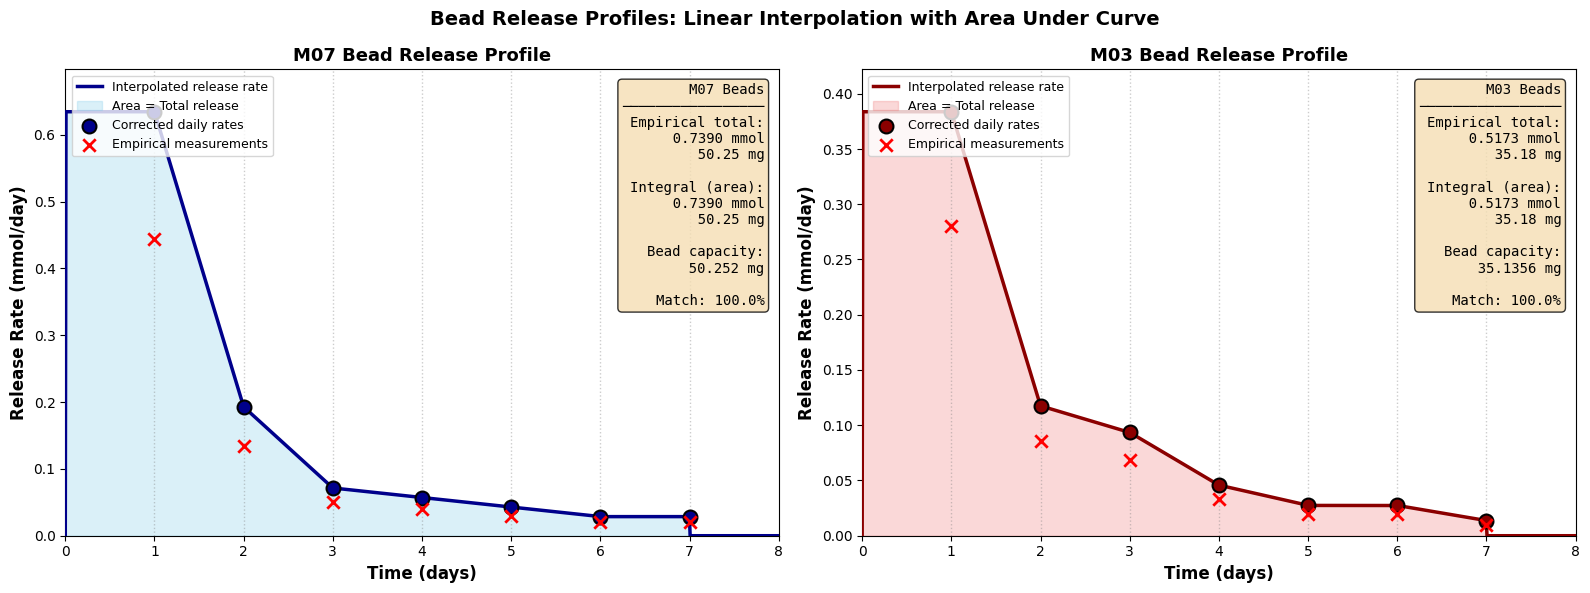


✓ Release profile visualizations generated!
  • Shaded area represents the integral (total formate released)
  • Blue/Red dots show corrected rates for linear interpolation
  • Red X markers show original empirical measurements
  • The integral exactly matches the empirical total formate content


In [204]:
# Visualize the interpolated release profiles and area under curve
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Bead Release Profiles: Linear Interpolation with Area Under Curve', 
             fontsize=14, fontweight='bold')

def plot_release_with_area(ax, release_profile, empirical_profile, bead_name, 
                           formate_content, color_fill, color_line):
    """
    Plot the interpolated release rate curve with shaded area showing integral.
    """
    days = sorted(release_profile.keys())
    max_day = max(days)  # Get max day from actual data
    
    # Create high-resolution time array for smooth curve
    time_fine = np.linspace(0, max_day + 1, 1000)
    rates_fine = []
    
    for t in time_fine:
        if t <= 0 or t > max_day:
            rates_fine.append(0)
        else:
            # Linear interpolation
            day_floor = int(np.floor(t))
            day_ceil = int(np.ceil(t))
            
            if day_floor == day_ceil or day_floor < 1:
                day_floor = max(1, day_floor)
                rates_fine.append(release_profile.get(day_floor, 0))
            elif day_ceil > max_day:
                rates_fine.append(0)
            else:
                rate_floor = release_profile.get(day_floor, 0)
                rate_ceil = release_profile.get(day_ceil, 0)
                fraction = t - day_floor
                rates_fine.append(rate_floor + fraction * (rate_ceil - rate_floor))
    
    # Plot the smooth interpolated curve
    ax.plot(time_fine, rates_fine, color=color_line, linewidth=2.5, 
            label='Interpolated release rate', zorder=3)
    
    # Fill area under curve (the integral)
    ax.fill_between(time_fine, 0, rates_fine, alpha=0.3, color=color_fill, 
                    label='Area = Total release', zorder=1)
    
    # Plot corrected daily values as points
    day_values = [release_profile[d] for d in days]
    ax.scatter(days, day_values, color=color_line, s=100, zorder=4, 
              edgecolors='black', linewidths=1.5, label='Corrected daily rates')
    
    # Plot empirical values as comparison
    empirical_values = [empirical_profile[d] for d in days]
    ax.scatter(days, empirical_values, color='red', s=80, zorder=5, 
              marker='x', linewidths=2, label='Empirical measurements')
    
    # Add vertical lines at day boundaries to show daily segments
    for day in range(1, max_day + 1):
        ax.axvline(x=day, color='gray', linestyle=':', alpha=0.4, linewidth=1)
    
    # Calculate integral and convert to mg
    integral_mmol = 0.0
    for i in range(len(days) - 1):
        day1, day2 = days[i], days[i + 1]
        rate1, rate2 = release_profile[day1], release_profile[day2]
        integral_mmol += 0.5 * (rate1 + rate2) * (day2 - day1)
    # Add final triangle
    integral_mmol += 0.5 * release_profile[days[-1]] * 1
    
    integral_mg = integral_mmol * FORMATE_MW
    empirical_sum_mmol = sum(empirical_profile.values())
    empirical_sum_mg = empirical_sum_mmol * FORMATE_MW
    
    # Add text box with summary
    textstr = f'{bead_name} Beads\n'
    textstr += f'─────────────────\n'
    textstr += f'Empirical total:\n'
    textstr += f'  {empirical_sum_mmol:.4f} mmol\n'
    textstr += f'  {empirical_sum_mg:.2f} mg\n\n'
    textstr += f'Integral (area):\n'
    textstr += f'  {integral_mmol:.4f} mmol\n'
    textstr += f'  {integral_mg:.2f} mg\n\n'
    textstr += f'Bead capacity:\n'
    textstr += f'  {formate_content} mg\n\n'
    textstr += f'Match: {integral_mg/empirical_sum_mg*100:.1f}%'
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    ax.text(0.98, 0.97, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', horizontalalignment='right', 
            bbox=props, family='monospace')
    
    ax.set_xlabel('Time (days)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Release Rate (mmol/day)', fontsize=12, fontweight='bold')
    ax.set_title(f'{bead_name} Bead Release Profile', fontsize=13, fontweight='bold')
    ax.legend(loc='upper left', fontsize=9)
    ax.set_xlim(0, max_day + 1)
    ax.set_xlim(0, 8)
    ax.set_ylim(0, max(release_profile.values()) * 1.1)

# Plot M07 beads
plot_release_with_area(axes[0], M07_BEAD_RELEASE, M07_EMPIRICAL, 'M07', 
                       M07_FORMATE_CONTENT, 'skyblue', 'darkblue')

# Plot M03 beads
plot_release_with_area(axes[1], M03_BEAD_RELEASE, M03_EMPIRICAL, 'M03', 
                       M03_FORMATE_CONTENT, 'lightcoral', 'darkred')

plt.tight_layout()
plt.show()

print("\n✓ Release profile visualizations generated!")
print("  • Shaded area represents the integral (total formate released)")
print("  • Blue/Red dots show corrected rates for linear interpolation")
print("  • Red X markers show original empirical measurements")
print("  • The integral exactly matches the empirical total formate content")

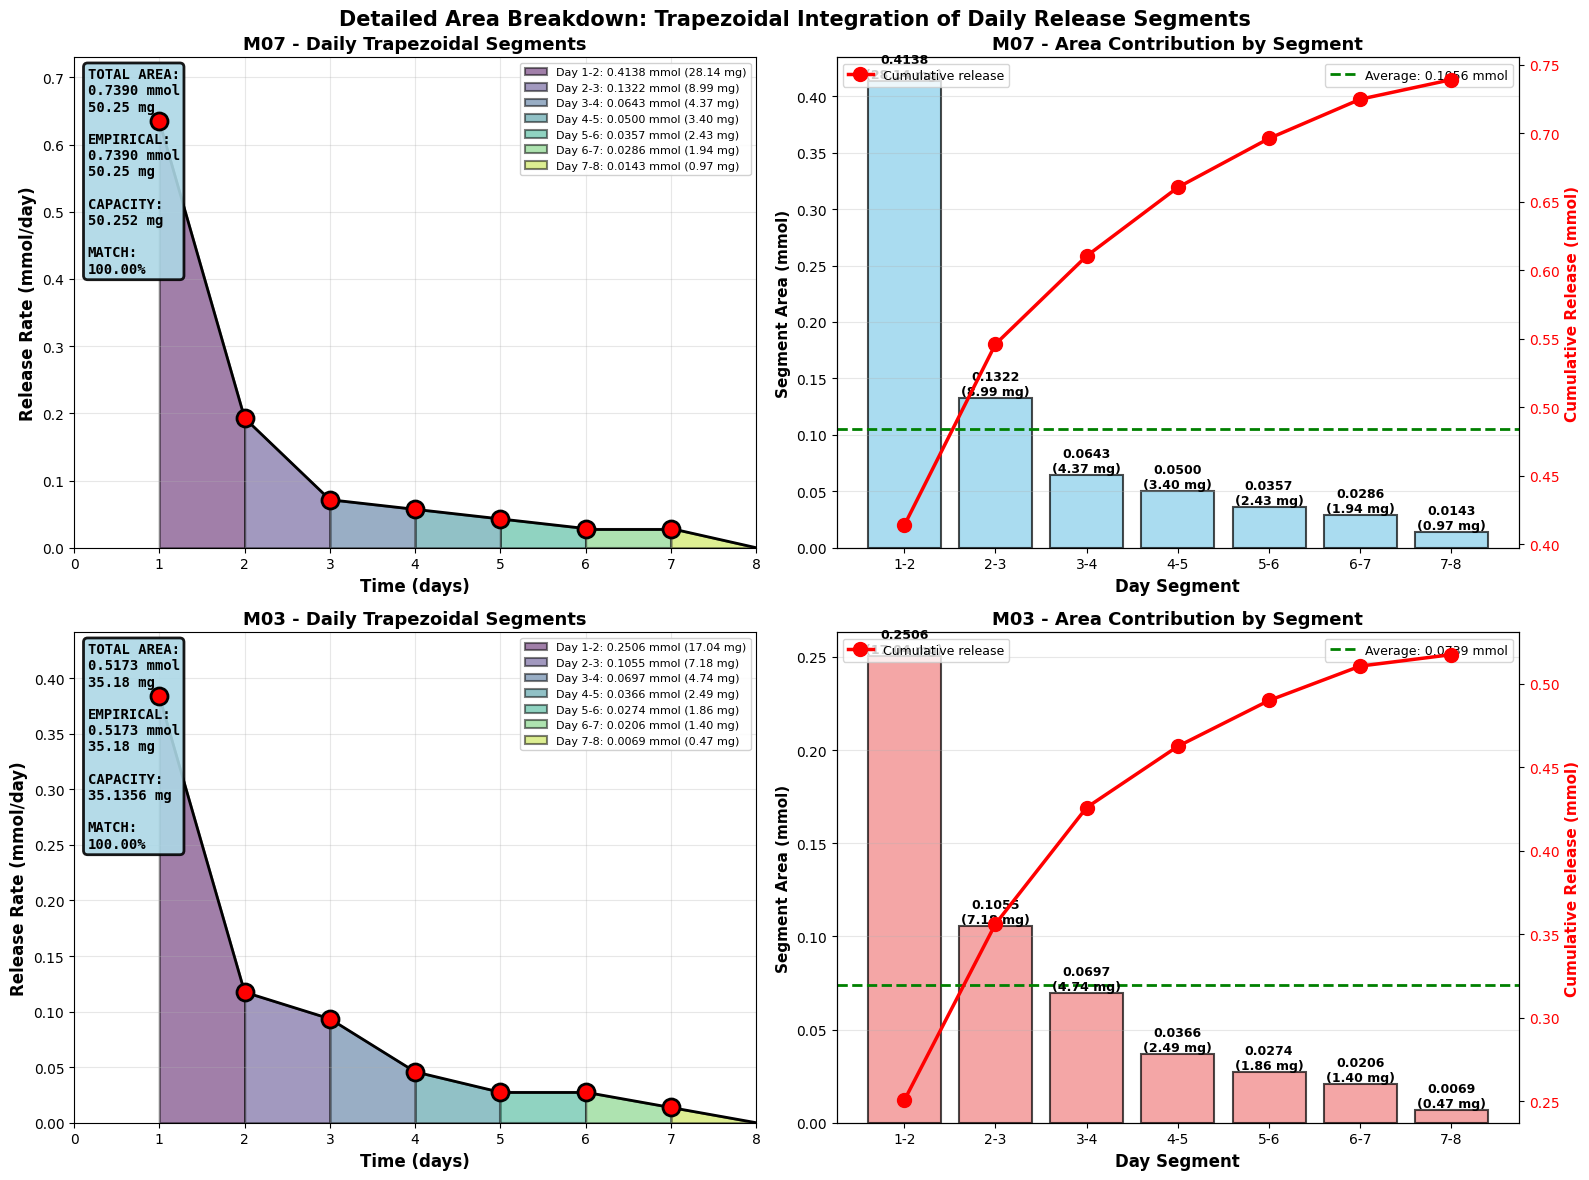


✓ Detailed area breakdown generated!
  • Left plots show each daily trapezoidal segment with its area
  • Right plots show bar charts of area contribution per segment
  • Cumulative red line shows progressive formate release
  • Total area under all segments = empirical formate content


In [205]:
# Create detailed breakdown showing area for each daily segment
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Detailed Area Breakdown: Trapezoidal Integration of Daily Release Segments', 
             fontsize=15, fontweight='bold')

def plot_daily_segments(ax, release_profile, empirical_profile, bead_name, formate_content):
    """
    Plot each daily segment with its trapezoidal area highlighted.
    """
    days = sorted(release_profile.keys())
    
    # Create color map for different days
    colors = plt.cm.viridis(np.linspace(0, 0.9, len(days)))
    
    # Calculate and plot each daily segment
    daily_areas_mmol = []
    daily_areas_mg = []
    
    for i in range(len(days) - 1):
        day1, day2 = days[i], days[i + 1]
        rate1, rate2 = release_profile[day1], release_profile[day2]
        
        # Trapezoidal area for this segment
        area_mmol = 0.5 * (rate1 + rate2) * (day2 - day1)
        area_mg = area_mmol * FORMATE_MW
        daily_areas_mmol.append(area_mmol)
        daily_areas_mg.append(area_mg)
        
        # Plot the trapezoid
        time_segment = [day1, day2]
        rate_segment = [rate1, rate2]
        
        ax.fill_between(time_segment, 0, rate_segment, 
                       alpha=0.5, color=colors[i], 
                       label=f'Day {day1}-{day2}: {area_mmol:.4f} mmol ({area_mg:.2f} mg)',
                       edgecolor='black', linewidth=1.5)
        
        ax.plot(time_segment, rate_segment, color='black', linewidth=2, zorder=3)
    
    # Add final triangle (day 7 to 0)
    last_day = days[-1]
    last_rate = release_profile[last_day]
    final_area_mmol = 0.5 * last_rate * 1
    final_area_mg = final_area_mmol * FORMATE_MW
    daily_areas_mmol.append(final_area_mmol)
    daily_areas_mg.append(final_area_mg)
    
    ax.fill_between([last_day, last_day + 1], 0, [last_rate, 0], 
                   alpha=0.5, color=colors[-1], 
                   label=f'Day {last_day}-{last_day+1}: {final_area_mmol:.4f} mmol ({final_area_mg:.2f} mg)',
                   edgecolor='black', linewidth=1.5)
    ax.plot([last_day, last_day + 1], [last_rate, 0], color='black', linewidth=2, zorder=3)
    
    # Plot corrected rates as points
    day_values = [release_profile[d] for d in days]
    ax.scatter(days, day_values, color='red', s=150, zorder=4, 
              edgecolors='black', linewidths=2, marker='o')
    
    # Calculate totals
    total_mmol = sum(daily_areas_mmol)
    total_mg = sum(daily_areas_mg)
    empirical_mmol = sum(empirical_profile.values())
    empirical_mg = empirical_mmol * FORMATE_MW
    
    ax.set_xlabel('Time (days)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Release Rate (mmol/day)', fontsize=12, fontweight='bold')
    ax.set_title(f'{bead_name} - Daily Trapezoidal Segments', fontsize=13, fontweight='bold')
    ax.legend(loc='upper right', fontsize=8, framealpha=0.9)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, 8)
    ax.set_ylim(0, max(release_profile.values()) * 1.15)
    
    # Add summary text
    textstr = f'TOTAL AREA:\n'
    textstr += f'{total_mmol:.4f} mmol\n'
    textstr += f'{total_mg:.2f} mg\n\n'
    textstr += f'EMPIRICAL:\n'
    textstr += f'{empirical_mmol:.4f} mmol\n'
    textstr += f'{empirical_mg:.2f} mg\n\n'
    textstr += f'CAPACITY:\n'
    textstr += f'{formate_content} mg\n\n'
    textstr += f'MATCH:\n'
    textstr += f'{total_mg/empirical_mg*100:.2f}%'
    
    props = dict(boxstyle='round', facecolor='lightblue', alpha=0.9, edgecolor='black', linewidth=2)
    ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', horizontalalignment='left', 
            bbox=props, family='monospace', fontweight='bold')
    
    return daily_areas_mmol, daily_areas_mg

def plot_area_bars(ax, daily_areas_mmol, daily_areas_mg, bead_name, color):
    """
    Create bar chart showing contribution of each daily segment.
    """
    n_segments = len(daily_areas_mmol)
    x = np.arange(n_segments)
    
    # Create bars
    bars = ax.bar(x, daily_areas_mmol, color=color, edgecolor='black', 
                   linewidth=1.5, alpha=0.7)
    
    # Add value labels on bars
    for i, (bar, mmol, mg) in enumerate(zip(bars, daily_areas_mmol, daily_areas_mg)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{mmol:.4f}\n({mg:.2f} mg)',
                ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # Add cumulative line
    cumulative = np.cumsum(daily_areas_mmol)
    ax2 = ax.twinx()
    ax2.plot(x, cumulative, 'ro-', linewidth=2.5, markersize=10, 
             label='Cumulative release', zorder=5)
    ax2.set_ylabel('Cumulative Release (mmol)', fontsize=11, fontweight='bold', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    ax2.legend(loc='upper left', fontsize=9)
    
    segment_labels = [f'{i+1}-{i+2}' for i in range(n_segments-1)] + [f'{n_segments}-{n_segments+1}']
    ax.set_xlabel('Day Segment', fontsize=12, fontweight='bold')
    ax.set_ylabel('Segment Area (mmol)', fontsize=11, fontweight='bold')
    ax.set_title(f'{bead_name} - Area Contribution by Segment', fontsize=13, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(segment_labels)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add total line
    total = sum(daily_areas_mmol)
    ax.axhline(y=total/n_segments, color='green', linestyle='--', linewidth=2, 
               label=f'Average: {total/n_segments:.4f} mmol')
    ax.legend(loc='upper right', fontsize=9)

# Plot M07 segments and bars
m07_areas_mmol, m07_areas_mg = plot_daily_segments(
    axes[0, 0], M07_BEAD_RELEASE, M07_EMPIRICAL, 'M07', M07_FORMATE_CONTENT
)
plot_area_bars(axes[0, 1], m07_areas_mmol, m07_areas_mg, 'M07', 'skyblue')

# Plot M03 segments and bars
m03_areas_mmol, m03_areas_mg = plot_daily_segments(
    axes[1, 0], M03_BEAD_RELEASE, M03_EMPIRICAL, 'M03', M03_FORMATE_CONTENT
)
plot_area_bars(axes[1, 1], m03_areas_mmol, m03_areas_mg, 'M03', 'lightcoral')

plt.tight_layout()
plt.show()

print("\n✓ Detailed area breakdown generated!")
print("  • Left plots show each daily trapezoidal segment with its area")
print("  • Right plots show bar charts of area contribution per segment")
print("  • Cumulative red line shows progressive formate release")
print("  • Total area under all segments = empirical formate content")

In [206]:
class Bead:
    """
    Represents a single formate-releasing bead with continuous release kinetics.
    
    Attributes:
        bead_type (str): Type of bead ('M07' or 'M03')
        age (float): Current age of the bead in days (can be fractional)
        release_profile (dict): Daily release rates for this bead type
        day_added (float): The day this bead was added to the experiment
    """
    
    def __init__(self, bead_type, day_added=0):
        """
        Initialize a bead with a specific type.
        
        Args:
            bead_type (str): 'M07' or 'M03'
            day_added (float): The day this bead was added (for age tracking)
        """
        self.bead_type = bead_type
        self.day_added = day_added
        
        # Select the appropriate release profile
        if bead_type == 'M07':
            self.release_profile = M07_BEAD_RELEASE
        elif bead_type == 'M03':
            self.release_profile = M03_BEAD_RELEASE
        else:
            raise ValueError(f"Unknown bead type: {bead_type}")
    
    def get_release_rate(self, current_time):
        """
        Get the formate release rate at a specific time using linear interpolation.
        
        This provides smooth transitions between daily values rather than step changes.
        For example, at day 1.5, the release rate will be halfway between day 1 and day 2 values.
        
        Args:
            current_time (float): Current time in days since experiment start
            
        Returns:
            float: Release rate in mmol/day (0 if bead is exhausted)
        """
        # Calculate bead age
        bead_age = current_time - self.day_added
        
        # If bead hasn't been added yet or is exhausted, return 0
        if bead_age <= 0:
            return 0.0
        
        max_day = max(self.release_profile.keys())
        if bead_age > max_day:
            return 0.0
        
        # Get the integer day boundaries for interpolation
        day_floor = int(np.floor(bead_age))
        day_ceil = int(np.ceil(bead_age))
        
        # Handle edge case where we're exactly on a day boundary
        if day_floor == day_ceil:
            return self.release_profile.get(day_floor, 0.0)
        
        # Linear interpolation between two daily values
        if day_floor < 1:
            day_floor = 1
        if day_ceil > max_day:
            return 0.0
        
        rate_floor = self.release_profile.get(day_floor, 0.0)
        rate_ceil = self.release_profile.get(day_ceil, 0.0)
        
        # Calculate fractional part for interpolation
        fraction = bead_age - day_floor
        
        # Linear interpolation: rate = rate_floor + fraction * (rate_ceil - rate_floor)
        interpolated_rate = rate_floor + fraction * (rate_ceil - rate_floor)
        
        return interpolated_rate

print("✓ Bead class defined with linear interpolation for smooth release kinetics")

✓ Bead class defined with linear interpolation for smooth release kinetics


In [207]:
class ExperimentManager:
    """
    Manages all beads in the formate-release experiment.
    
    Attributes:
        beads (list): List of all Bead objects in the experiment
    """
    
    def __init__(self):
        """Initialize an empty experiment with no beads."""
        self.beads = []
    
    def add_bead(self, bead_type, day_added):
        """
        Add a new bead to the experiment.
        
        Args:
            bead_type (str): 'M07' or 'M03'
            day_added (float): The day this bead is added (for age tracking)
        """
        new_bead = Bead(bead_type, day_added)
        self.beads.append(new_bead)
    
    def get_total_release(self, current_time):
        """
        Calculate total formate release from all beads at a specific time.
        
        Args:
            current_time (float): Current time in days
            
        Returns:
            float: Total release rate in mmol/day
        """
        total = sum(bead.get_release_rate(current_time) for bead in self.beads)
        return total

print("✓ ExperimentManager class defined")

✓ ExperimentManager class defined


In [208]:
class MonodKinetics:
    """
    Models bacterial growth and formate consumption using Monod kinetics.
    
    Key equations:
    - Growth rate: μ = μ_max * S / (K_s + S)
    - Consumption rate: dS/dt = -μ * X / Y_xs
    
    Attributes:
        mu_max (float): Maximum specific growth rate (1/day)
        K_s (float): Half-saturation constant (mmol/L)
        Y_xs (float): Yield coefficient (OD per mmol/L substrate)
    
    """
    
    def __init__(self, mu_max, K_s, Y_xs):
        """
        Initialize Monod kinetics parameters.
        
        Args:
            mu_max (float): Maximum growth rate (1/day)
            K_s (float): Half-saturation constant (mmol/L)
            Y_xs (float): Yield coefficient (OD per mmol/L)
        """
        self.mu_max = mu_max
        self.K_s = K_s
        self.Y_xs = Y_xs
    
    def growth_rate(self, S):
        """
        Calculate specific growth rate at given substrate concentration.
        
        Args:
            S (float): Substrate concentration (mmol/L)
            
        Returns:
            float: Specific growth rate μ (1/day)
        """
        if S <= 0:
            return 0
        return self.mu_max * S / (self.K_s + S)
    
    def consumption_rate(self, S, X):
        """
        Calculate substrate consumption rate.
        
        Args:
            S (float): Substrate concentration (mmol/L)
            X (float): Bacterial concentration (OD)
            
        Returns:
            float: Consumption rate (mmol/L/day)
        """
        mu = self.growth_rate(S)
        return mu * X / self.Y_xs

print("✓ MonodKinetics class defined")

✓ MonodKinetics class defined


In [209]:
class ConstantSubstrateCalculator:
    """
    Integrated model for maintaining constant substrate concentration.
    
    IMPROVED ALGORITHM FEATURES:
    ==============================
    ✓ FLEXIBLE BEAD COUNTS: M07/M03 ratio varies per day based on current needs
    ✓ GROWTH-BASED ESTIMATION: Uses exponential OD projection with Monod kinetics
    ✓ FLUCTUATION MINIMIZATION: Matches release profile to consumption trajectory
    
    This class combines:
    1. Bead release kinetics (from ExperimentManager)
    2. Bacterial consumption (from MonodKinetics)
    3. Automatic bead scheduling to maintain target substrate level
    4. Adaptive bead ratio optimization based on deficit urgency and time horizon
    
    Attributes:
        volume (float): Culture volume (L)
        monod (MonodKinetics): Bacterial growth model
        target_concentration (float): Desired substrate concentration (mmol/L)
        tolerance (float): Acceptable deviation from target (mmol/L)
    """
    
    def __init__(self, volume, monod_params, target_concentration, tolerance=0.1):
        """
        Initialize the integrated calculator.
        
        Args:
            volume (float): Culture volume in liters
            monod_params (dict): {'mu_max', 'K_s', 'Y_xs'} for MonodKinetics
            target_concentration (float): Target substrate concentration (mmol/L)
            tolerance (float): Acceptable deviation as fraction (e.g., 0.1 = ±10%)
        """
        self.volume = volume
        self.monod = MonodKinetics(**monod_params)
        self.target_concentration = target_concentration
        self.tolerance = tolerance
    
    def calculate_bead_schedule(self, initial_od, experiment_days=7, dt=0.01):
        """
        Calculate optimal bead addition schedule with dynamic bacterial growth.
        
        IMPROVED ALGORITHM:
        - Variable bead counts per day (not fixed ratio)
        - Growth-rate-based consumption estimation
        - Fluctuation minimization through predictive release matching
        
        Bacterial growth is calculated using Monod kinetics based on substrate availability.
        Both substrate and bacterial density are solved dynamically in the simulation.
        
        Args:
            initial_od (float): Initial bacterial optical density
            experiment_days (int): Total experiment duration in days
            dt (float): Time step for simulation (days, default=0.01 for accuracy)
            
        Returns:
            dict: Results containing:
                - 'times': Array of time points
                - 'substrate': Substrate concentration over time
                - 'od': Bacterial density over time (calculated dynamically)
                - 'bead_schedule': {day: {'M07': count, 'M03': count}}
                - 'release_rates': Total formate release rate over time
        """
        # Initialize experiment manager
        manager = ExperimentManager()
        
        # === DAY 0: BUILD UP SUBSTRATE FROM ZERO ===
        # On Day 0, substrate starts at 0 and we need to reach target concentration
        # Bacteria are inoculated but won't consume much during lag phase (first ~1 day)
        # So we need beads that will BUILD UP 20 mmol/L, not just match consumption
        
        # Total formate needed to reach target concentration
        total_formate_needed = self.target_concentration * self.volume  # mmol
        
        # Add some buffer for early consumption (but bacteria are in lag phase)
        # During first 24 hours, consumption is minimal due to lag phase
        # Estimate ~10% buffer for minimal early consumption
        total_formate_needed *= 1.1
        
        # Calculate total release capacities for reference
        m07_total_release = sum(M07_BEAD_RELEASE.values())
        m03_total_release = sum(M03_BEAD_RELEASE.values())
        
        # Initial beads: Favor M07 for rapid buildup, but include M03 for sustained release
        # M07 provides ~70% of day 1 release, M03 provides ~30%
        # This ensures substrate builds up quickly to target within first day
        m07_fraction = 0.7  # 70% of need from M07 (rapid buildup)
        m03_fraction = 0.3  # 30% of need from M03 (sustained support)
        
        initial_m07 = max(1, int(np.ceil(total_formate_needed * m07_fraction / m07_total_release)))
        initial_m03 = max(1, int(np.ceil(total_formate_needed * m03_fraction / m03_total_release)))
        
        for _ in range(initial_m07):
            manager.add_bead('M07', 0)
        for _ in range(initial_m03):
            manager.add_bead('M03', 0)
        
        # Simulation arrays
        times = np.arange(0, experiment_days + dt, dt)
        substrate = np.zeros_like(times)
        od = np.zeros_like(times)
        release_rates = np.zeros_like(times)
        cumulative_consumed = np.zeros_like(times)  # Track total formate consumed
        
        # Initialize conditions - START REALISTICALLY
        # Day 0: Beads added, substrate starts at ZERO
        # Bacteria added, but at very low substrate concentration initially
        substrate[0] = 0.0  # No substrate initially - will build up from bead release
        od[0] = initial_od  # Bacteria present but won't grow much until substrate available
        cumulative_consumed[0] = 0.0
        
        # Track bead additions (record initial beads)
        bead_schedule = {0: {'M07': initial_m07, 'M03': initial_m03}}
        
        # Calculate tolerance bounds for symmetric oscillations
        # Lower bound: 0.85x target (allows 15% undershoot)
        # Upper bound: 1.15x target (allows 15% overshoot)
        # This creates symmetric cycling around the target concentration
        lower_bound = self.target_concentration * 0.85
        upper_bound = self.target_concentration * 1.15
        
        # Simulate with fine time resolution - fully coupled dynamics
        for i in range(1, len(times)):
            current_time = times[i]
            current_day = int(current_time)
            
            # Get current release rate from all beads (with continuous interpolation)
            release_rate = manager.get_total_release(current_time)  # mmol/day
            release_rates[i] = release_rate
            
            # Calculate bacterial growth rate from Monod kinetics (based on ACTUAL substrate)
            mu = self.monod.growth_rate(substrate[i-1])  # 1/day
            
            # Calculate substrate consumption rate
            consumption_rate = self.monod.consumption_rate(substrate[i-1], od[i-1])  # mmol/L/day
            
            # Track cumulative consumption (mmol/L/day * L * day = mmol)
            consumption_amount = consumption_rate * self.volume * dt  # mmol consumed in this time step
            cumulative_consumed[i] = cumulative_consumed[i-1] + consumption_amount
            
            # Update bacterial density: dOD/dt = μ * OD
            dOD_dt = mu * od[i-1]
            od[i] = od[i-1] + dOD_dt * dt
            
            # Update substrate concentration: dS/dt = (release / volume) - consumption
            dS_dt = (release_rate / self.volume) - consumption_rate
            substrate[i] = substrate[i-1] + dS_dt * dt
            
            # Ensure non-negative values
            substrate[i] = max(0, substrate[i])
            od[i] = max(0, od[i])
            
            # Check if we need to add beads ONCE PER DAY (at day boundaries only)
            # This checks if we're at a day boundary (e.g., day 1.0, 2.0, 3.0, etc.)
            time_fraction = current_time - current_day
            should_check = abs(time_fraction) < dt/2 and current_day > 0
            
            if should_check:
                # SMART APPROACH: Add beads based on substrate level AND consumption trend
                # Add beads if:
                # 1. Substrate is below 0.95x target (prevent overshoot), OR
                # 2. Substrate is falling and consumption rate is high relative to release
                current_consumption = self.monod.consumption_rate(substrate[i], od[i]) * self.volume
                current_release = release_rate
                consumption_ratio = current_consumption / (current_release + 1e-6)
                
                # Condition 1: Substrate below threshold
                needs_beads_low_substrate = substrate[i] < self.target_concentration * 0.95
                
                # Condition 2: Consumption exceeding 60% of release (imbalance developing)
                # AND substrate not too high (within 10% above target)
                needs_beads_imbalance = (consumption_ratio > 0.6 and 
                                        substrate[i] < self.target_concentration * 1.1)
                
                # Condition 3: Proactive - if consumption is significant and substrate within range
                # Add beads to stay ahead (especially important after day 3)
                needs_beads_proactive = (current_day >= 3 and 
                                        current_consumption > 5 and  # Significant consumption
                                        substrate[i] < self.target_concentration * 1.05)
                
                if needs_beads_low_substrate or needs_beads_imbalance or needs_beads_proactive:
                    # Substrate not too high - consider adding beads
                    deficit_concentration = self.target_concentration - substrate[i]  # mmol/L
                    deficit = deficit_concentration * self.volume  # mmol
                    
                    # === IMPROVED GROWTH-BASED CONSUMPTION ESTIMATION ===
                    # Use exponential growth model with Monod kinetics at CURRENT substrate concentration
                    # This accounts for lag phase and substrate limitation
                    
                    # Calculate specific growth rate at CURRENT substrate concentration (not target!)
                    # This is critical for accurate prediction during lag phase when substrate is low
                    mu_current = self.monod.growth_rate(substrate[i])  # 1/day
                    
                    # Check upcoming release from EXISTING beads (next 1-2 days)
                    # This prevents over-adding when existing beads are still releasing heavily
                    upcoming_release_1day = manager.get_total_release(current_time + 1.0)
                    upcoming_release_2day = manager.get_total_release(current_time + 2.0)
                    avg_upcoming_release = (upcoming_release_1day + upcoming_release_2day) / 2
                    
                    # Days remaining in experiment
                    days_remaining = experiment_days - current_day
                    
                    # Use ADAPTIVE projection window: longer early, shorter late
                    # Early days: look ahead 2 days to anticipate growth
                    # Late days: look ahead 1.5 days as consumption accelerates
                    if current_day <= 3:
                        projection_window = min(2, days_remaining)
                    else:
                        projection_window = min(1.5, days_remaining)
                    
                    # Exponential growth projection: OD(t) = OD_0 * e^(μ*t)
                    # Use CURRENT growth rate, not target - accounts for substrate limitation!
                    time_points = np.linspace(0, projection_window, num=max(15, int(projection_window * 10)))
                    projected_ods = od[i] * np.exp(mu_current * time_points)
                    
                    # Calculate consumption at each projected time point
                    # Use substrate concentration that's expected (gradually approaching target)
                    # Start from current substrate, assume it will approach target as beads are added
                    projected_consumptions = []
                    for idx, od_proj in enumerate(projected_ods):
                        # Estimate substrate availability: blend current and target based on time progress
                        time_fraction = time_points[idx] / projection_window if projection_window > 0 else 0
                        estimated_substrate = substrate[i] + (self.target_concentration - substrate[i]) * time_fraction
                        estimated_substrate = max(0, min(estimated_substrate, self.target_concentration * 1.2))
                        projected_consumptions.append(
                            self.monod.consumption_rate(estimated_substrate, od_proj)
                        )
                    
                    # Average consumption rate over projection window (mmol/L/day)
                    avg_future_consumption = np.mean(projected_consumptions)
                    daily_consumption = avg_future_consumption * self.volume  # mmol/day
                    
                    # ADAPTIVE buffer: more aggressive in late days when consumption accelerates
                    # But reduce buffer when substrate is already close to target to prevent overshoot
                    # Early days (1-3): 0.8x buffer (conservative during lag phase)
                    # Late days (4+): 1.0x buffer (balanced - not too aggressive to prevent overshoot)
                    if current_day <= 3:
                        buffer_factor = 0.8
                    else:
                        buffer_factor = 1.0
                    
                    # Further reduce if substrate is already close to target (within 20% of deficit)
                    if deficit < self.target_concentration * 0.2:
                        buffer_factor *= 0.7  # Be extra conservative near target
                    
                    # Total needed: restore deficit + buffered consumption for projection window
                    total_needed = deficit + daily_consumption * projection_window * buffer_factor
                    
                    # CRITICAL: Subtract the upcoming release from existing beads!
                    # This prevents over-addition when recently added beads are still in high-release phase
                    # Only subtract if we're in the buildup phase (days 0-3) where this matters most
                    if current_day <= 3:
                        # Existing beads will provide this much over the projection window
                        existing_supply = avg_upcoming_release * projection_window
                        total_needed = max(0, total_needed - existing_supply * 0.5)  # Subtract 50% of upcoming release
                    
                    # === FLEXIBLE BEAD RATIO OPTIMIZATION ===
                    # Instead of fixed ratio, optimize M07/M03 mix based on:
                    # 1. Time horizon (early vs late in experiment)
                    # 2. Immediate vs sustained needs
                    # 3. Current consumption trajectory
                    
                    # Calculate how much each bead would contribute on day 1 vs over full lifetime
                    m07_day1 = M07_BEAD_RELEASE.get(1, 0)  # Immediate release
                    m03_day1 = M03_BEAD_RELEASE.get(1, 0)
                    
                    # If deficit is large, prioritize M07 (high immediate release)
                    # If consumption is steady, prioritize M03 (sustained release)
                    deficit_ratio = deficit / (daily_consumption + 1e-6)  # How urgent is the need?
                    
                    if deficit_ratio > 0.5:
                        # Large deficit - need immediate release (favor M07)
                        m07_weight = 0.6
                        m03_weight = 0.4
                    elif days_remaining > 3:
                        # Early in experiment - balance immediate + sustained
                        m07_weight = 0.4
                        m03_weight = 0.6
                    else:
                        # Late in experiment - favor M07 for short-term boost
                        m07_weight = 0.5
                        m03_weight = 0.5
                    
                    # Distribute needed amount with optimized weights
                    m07_share = total_needed * m07_weight
                    m03_share = total_needed * m03_weight
                    
                    # Convert to bead counts (allow 0 beads if share is very small)
                    m07_needed = int(np.ceil(m07_share / m07_total_release)) if m07_share > 0.01 else 0
                    m03_needed = int(np.ceil(m03_share / m03_total_release)) if m03_share > 0.01 else 0
                    
                    # Ensure at least some beads if total_needed is significant
                    if total_needed > 0.1 and m07_needed == 0 and m03_needed == 0:
                        # Decide which type based on urgency
                        if deficit_ratio > 0.3:
                            m07_needed = 1
                        else:
                            m03_needed = 1
                    
                    # Add beads at the current day (integer day)
                    for _ in range(m07_needed):
                        manager.add_bead('M07', current_day)
                    for _ in range(m03_needed):
                        manager.add_bead('M03', current_day)
                    
                    # Record in schedule (integer days only)
                    schedule_key = current_day
                    if schedule_key in bead_schedule:
                        bead_schedule[schedule_key]['M07'] += m07_needed
                        bead_schedule[schedule_key]['M03'] += m03_needed
                    else:
                        bead_schedule[schedule_key] = {'M07': m07_needed, 'M03': m03_needed}
                
                elif substrate[i] > upper_bound:
                    # Substrate too high - no action (just let it be consumed)
                    # Could implement bead removal or waiting, but typically not needed
                    pass
        
        # Calculate consumption rates and HCl needs
        consumption_rates = np.zeros_like(times)
        hcl_needed_daily = np.zeros_like(times)
        
        for i in range(len(times)):
            consumption_rates[i] = self.monod.consumption_rate(substrate[i], od[i]) * self.volume
            # HCl needed equals consumption rate (1:1 molar ratio)
            hcl_needed_daily[i] = consumption_rates[i]
        
        # Calculate cumulative HCl needed (integral of consumption)
        hcl_needed_cumulative = cumulative_consumed.copy()  # Same as cumulative consumption
        
        return {
            'times': times,
            'substrate': substrate,
            'od': od,
            'bead_schedule': bead_schedule,
            'release_rates': release_rates,
            'consumption_rates': consumption_rates,
            'cumulative_consumed': cumulative_consumed,
            'hcl_needed_daily': hcl_needed_daily,
            'hcl_needed_cumulative': hcl_needed_cumulative
        }

In [210]:
# Create the integrated calculator
calculator = ConstantSubstrateCalculator(
    volume=VOLUME,
    monod_params=MONOD_PARAMS,
    target_concentration=TARGET_CONCENTRATION,
    tolerance=TOLERANCE
)

# Run the simulation with dynamic bacterial growth
print("Running fully coupled simulation...")
print("  • Bacterial growth calculated dynamically via Monod kinetics")
print("  • Substrate dynamics respond to both bead release and bacterial consumption")
print("  • HCl addition tracked to neutralize alkalinization (1:1 molar ratio)")
print("  • Time resolution: dt=0.01 days (high accuracy)")
print()
print("📅 Experiment Timeline:")
print(f"  Day 0 (t=0): Add initial beads to empty medium (substrate = 0)")
print(f"             Inoculate bacteria (OD={INITIAL_OD})")
print(f"             Substrate builds up from bead release over first hours/day")
print(f"  Days 1-{EXPERIMENT_DAYS}: Monitor substrate and add beads as needed to maintain target")
print(f"             Add HCl continuously to neutralize alkalinization from formate consumption")
print()
results = calculator.calculate_bead_schedule(
    initial_od=INITIAL_OD,
    experiment_days=EXPERIMENT_DAYS,
    dt=SIMULATION_DT
)

# Calculate HCl needed per day (based on PREVIOUS day's consumption)
def calculate_daily_hcl(results, experiment_days):
    """
    Calculate HCl needed for each day based on formate consumed during the PREVIOUS day.
    
    Day 0: No HCl (bacteria just inoculated, no consumption yet)
    Day 1: HCl based on consumption during Day 0→1
    Day 2: HCl based on consumption during Day 1→2
    etc.
    """
    daily_hcl = {}
    dt = results['times'][1] - results['times'][0]
    
    # Day 0: No HCl needed (bacteria haven't consumed anything yet)
    daily_hcl[0] = 0.0
    
    for day in range(1, experiment_days + 1):
        # HCl for Day N is based on consumption during Day (N-1) to Day N
        mask = (results['times'] >= (day - 1)) & (results['times'] < day)
        
        # Integrate consumption over the previous day
        if np.any(mask):
            hcl_consumed = np.sum(results['hcl_needed_daily'][mask] * dt)
            daily_hcl[day] = hcl_consumed
        else:
            daily_hcl[day] = 0.0
    
    return daily_hcl

daily_hcl = calculate_daily_hcl(results, EXPERIMENT_DAYS)

# Display bead schedule with HCl requirements
print("\n✓ Simulation complete!")
print("\n" + "=" * 80)
print("BEAD ADDITION SCHEDULE WITH HCl REQUIREMENTS")
print("=" * 80)
print("Note: HCl on Day N neutralizes formate consumed during Day (N-1)→N")
print("=" * 80)
print(f"{'Day':<5} {'M07 Beads':<12} {'M03 Beads':<12} {'HCl Needed (mmol)':<20} {'HCl (mg)':<12}")
print("-" * 80)

if results['bead_schedule']:
    for day in range(EXPERIMENT_DAYS + 1):
        if day in results['bead_schedule']:
            beads = results['bead_schedule'][day]
            m07 = beads.get('M07', 0)
            m03 = beads.get('M03', 0)
        else:
            m07 = 0
            m03 = 0
        
        hcl_mmol = daily_hcl.get(day, 0.0)
        hcl_mg = hcl_mmol * 36.46  # MW of HCl
        
        # Format output
        if day in results['bead_schedule'] or hcl_mmol > 0.01:
            bead_str = f"Add {m07} M07, {m03} M03" if (m07 > 0 or m03 > 0) else "No beads"
            print(f"{day:<5} {m07:<12} {m03:<12} {hcl_mmol:<20.3f} {hcl_mg:<12.2f}")
else:
    print("No beads needed (substrate remains stable)")

print("-" * 80)

# Calculate total beads used
total_m07 = sum(b.get('M07', 0) for b in results['bead_schedule'].values())
total_m03 = sum(b.get('M03', 0) for b in results['bead_schedule'].values())
total_hcl = sum(daily_hcl.values())

print(f"\n{'TOTALS:':<5} {total_m07:<12} {total_m03:<12} {total_hcl:<20.3f} {total_hcl*36.46:<12.2f}")
print("=" * 80)
print(f"\nFinal bacterial OD: {results['od'][-1]:.3f}")

# Display HCl requirements
print("\n" + "=" * 60)
print("HCl REQUIREMENTS FOR pH CONTROL")
print("=" * 60)
print("\nFormate consumption alkalinizes the media.")
print("HCl addition prevents this and maintains permeability.")
print(f"\nTotal formate consumed: {results['cumulative_consumed'][-1]:.2f} mmol")
print(f"Total HCl needed (1:1): {results['hcl_needed_cumulative'][-1]:.2f} mmol")
print(f"                        {results['hcl_needed_cumulative'][-1] * 36.46:.2f} mg")
print(f"                        {results['hcl_needed_cumulative'][-1] / 1000:.4f} mol")

# Convert to volume of concentrated HCl if needed
# Typical concentrated HCl is 37% w/w, density ~1.19 g/mL = ~12 M
conc_hcl_molarity = 12.0  # M (mol/L)
hcl_volume_ml = (results['hcl_needed_cumulative'][-1] / 1000) / conc_hcl_molarity * 1000
print(f"\nIf using 12M HCl stock:")
print(f"  Volume needed: {hcl_volume_ml:.2f} mL")
print(f"  (for {VOLUME} L culture over {EXPERIMENT_DAYS} days)")

print("\n" + "=" * 60)
# SANITY CHECK: Verify consumption matches yield coefficient and final OD
print("\n" + "=" * 60)
print("SANITY CHECK: Mass Balance Verification")
print("=" * 60)

# Expected relationship:
# Final OD = Initial OD + (Total formate consumed in mmol/L) × Yield coefficient
# Where: Total formate consumed = cumulative_consumed (mmol) / VOLUME (L)

total_consumed_mmol = results['cumulative_consumed'][-1]  # Total formate consumed (mmol)
total_consumed_mmol_per_L = total_consumed_mmol / VOLUME   # Concentration consumed (mmol/L)

initial_od = INITIAL_OD
final_od_actual = results['od'][-1]
yield_coefficient = MONOD_PARAMS['Y_xs']  # OD per mmol/L

# Calculate expected final OD based on consumption
od_increase_expected = total_consumed_mmol_per_L * yield_coefficient
final_od_expected = initial_od + od_increase_expected

# Calculate relative error
relative_error = abs(final_od_expected - final_od_actual) / final_od_actual * 100

print(f"\nInitial OD: {initial_od:.4f}")
print(f"Final OD (actual from simulation): {final_od_actual:.4f}")
print(f"\nTotal formate consumed: {total_consumed_mmol:.4f} mmol")
print(f"Total consumed per volume: {total_consumed_mmol_per_L:.4f} mmol/L")
print(f"Yield coefficient (Y_xs): {yield_coefficient} OD per mmol/L")
print(f"\nExpected OD increase: {od_increase_expected:.4f}")
print(f"Expected final OD: {final_od_expected:.4f}")
print(f"\nRelative error: {relative_error:.2f}%")

if relative_error < 0.1:
    print("\n✓ PASS: Mass balance verified (error < 0.1%)")
elif relative_error < 1.0:
    print("\n✓ PASS: Mass balance acceptable (error < 1%)")
else:
    print(f"\n⚠ WARNING: Mass balance error is {relative_error:.2f}%")
    print("   Check if yield coefficient or other parameters are correct.")

print("=" * 60)


Running fully coupled simulation...
  • Bacterial growth calculated dynamically via Monod kinetics
  • Substrate dynamics respond to both bead release and bacterial consumption
  • HCl addition tracked to neutralize alkalinization (1:1 molar ratio)
  • Time resolution: dt=0.01 days (high accuracy)

📅 Experiment Timeline:
  Day 0 (t=0): Add initial beads to empty medium (substrate = 0)
             Inoculate bacteria (OD=0.02)
             Substrate builds up from bead release over first hours/day
  Days 1-5: Monitor substrate and add beads as needed to maintain target
             Add HCl continuously to neutralize alkalinization from formate consumption


✓ Simulation complete!

BEAD ADDITION SCHEDULE WITH HCl REQUIREMENTS
Note: HCl on Day N neutralizes formate consumed during Day (N-1)→N
Day   M07 Beads    M03 Beads    HCl Needed (mmol)    HCl (mg)    
--------------------------------------------------------------------------------
0     7            5            0.000               

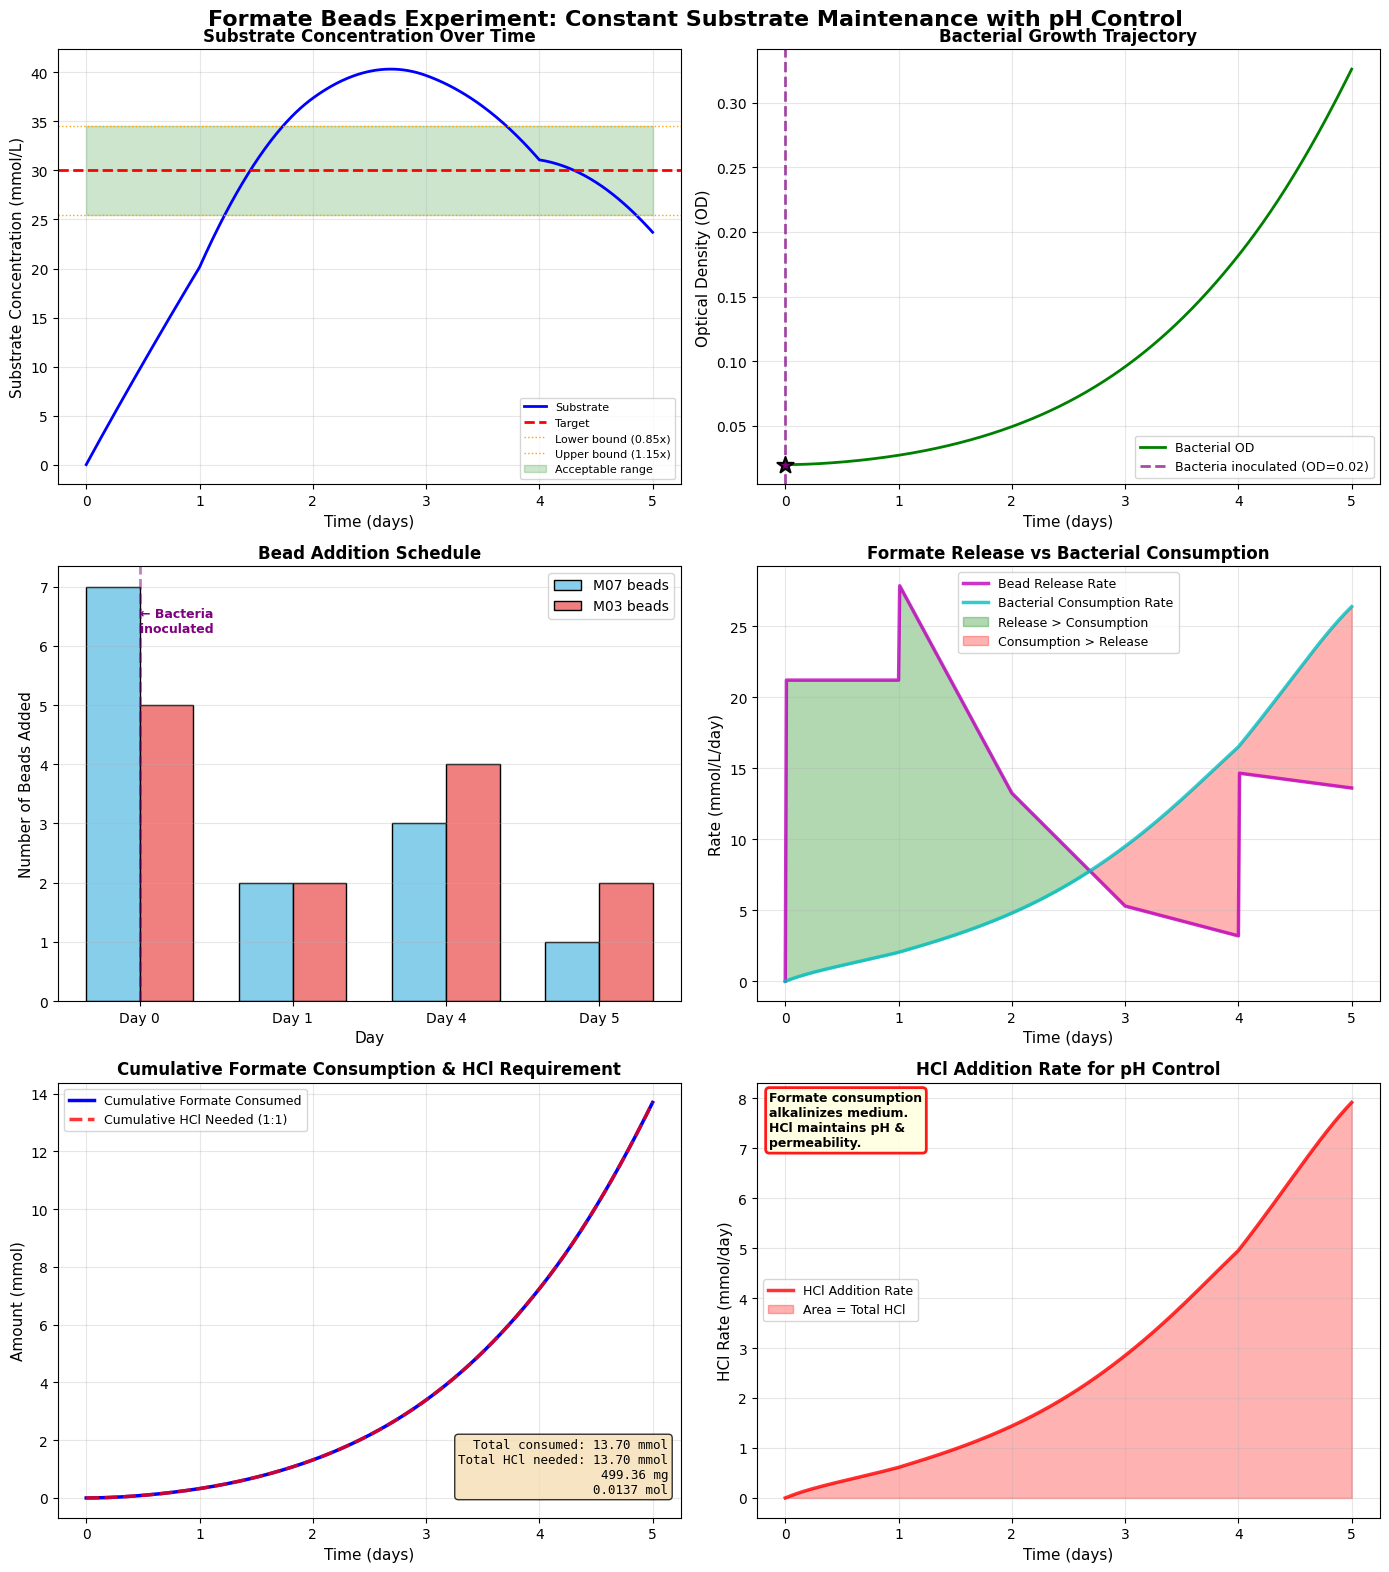


✓ Plots generated successfully!
  • Added HCl tracking plots (bottom row)
  • Left: Cumulative formate consumed and HCl needed
  • Right: HCl addition rate over time


In [211]:
# Create figure with 6 subplots (3x2 grid)
fig, axes = plt.subplots(3, 2, figsize=(14, 16))
fig.suptitle('Formate Beads Experiment: Constant Substrate Maintenance with pH Control', 
             fontsize=16, fontweight='bold')

# Plot 1: Substrate Concentration
ax1 = axes[0, 0]
ax1.plot(results['times'], results['substrate'], 'b-', linewidth=2, label='Substrate')
ax1.axhline(y=TARGET_CONCENTRATION, color='r', linestyle='--', linewidth=2, label='Target')
# Show actual algorithm bounds (0.85x - 1.15x for symmetric oscillations)
lower_bound = TARGET_CONCENTRATION * 0.85
upper_bound = TARGET_CONCENTRATION * 1.15
ax1.axhline(y=lower_bound, color='orange', linestyle=':', linewidth=1, label='Lower bound (0.85x)')
ax1.axhline(y=upper_bound, color='orange', linestyle=':', linewidth=1, label='Upper bound (1.15x)')
ax1.fill_between(results['times'], 
                  lower_bound, 
                  upper_bound, 
                  alpha=0.2, color='green', label='Acceptable range')
ax1.set_xlabel('Time (days)', fontsize=11)
ax1.set_ylabel('Substrate Concentration (mmol/L)', fontsize=11)
ax1.set_title('Substrate Concentration Over Time', fontsize=12, fontweight='bold')
ax1.legend(loc='best', fontsize=8)
ax1.grid(True, alpha=0.3)

# Plot 2: Bacterial Growth (OD) with inoculation marker
ax2 = axes[0, 1]
ax2.plot(results['times'], results['od'], 'g-', linewidth=2, label='Bacterial OD')
# Mark bacterial inoculation time (when OD starts from INITIAL_OD)
inoculation_day = 0  # Bacteria added at day 0 in this model
ax2.axvline(x=inoculation_day, color='purple', linestyle='--', linewidth=2, 
            label=f'Bacteria inoculated (OD={INITIAL_OD})', alpha=0.7)
ax2.scatter([inoculation_day], [INITIAL_OD], color='purple', s=150, zorder=5, 
            marker='*', edgecolors='black', linewidths=1.5)
ax2.set_xlabel('Time (days)', fontsize=11)
ax2.set_ylabel('Optical Density (OD)', fontsize=11)
ax2.set_title('Bacterial Growth Trajectory', fontsize=12, fontweight='bold')
ax2.legend(loc='best', fontsize=9)
ax2.grid(True, alpha=0.3)

# Plot 3: Bead Addition Schedule
ax3 = axes[1, 0]
if results['bead_schedule']:
    days = sorted(results['bead_schedule'].keys())
    m07_counts = [results['bead_schedule'][d].get('M07', 0) for d in days]
    m03_counts = [results['bead_schedule'][d].get('M03', 0) for d in days]
    
    x = np.arange(len(days))
    width = 0.35
    
    ax3.bar(x - width/2, m07_counts, width, label='M07 beads', color='skyblue', edgecolor='black')
    ax3.bar(x + width/2, m03_counts, width, label='M03 beads', color='lightcoral', edgecolor='black')
    ax3.set_xlabel('Day', fontsize=11)
    ax3.set_ylabel('Number of Beads Added', fontsize=11)
    ax3.set_title('Bead Addition Schedule', fontsize=12, fontweight='bold')
    ax3.set_xticks(x)
    ax3.set_xticklabels([f'Day {d}' for d in days])
    # Mark bacterial inoculation on bead schedule
    if inoculation_day in [0]:  # Day 0 is when bacteria added
        ax3.axvline(x=0, color='purple', linestyle='--', linewidth=2, alpha=0.5)
        ax3.text(0, max(max(m07_counts), max(m03_counts)) * 0.95, 
                '← Bacteria\ninoculated', fontsize=9, color='purple', 
                fontweight='bold', ha='left', va='top')
    ax3.legend(loc='best')
    ax3.grid(True, alpha=0.3, axis='y')
else:
    ax3.text(0.5, 0.5, 'No beads added\n(substrate stable)', 
             ha='center', va='center', fontsize=14)
    ax3.set_xlim(0, 1)
    ax3.set_ylim(0, 1)

# Plot 4: Release Rate vs Consumption Rate (converted to mmol/L/day to match substrate plot)
ax4 = axes[1, 1]
# Convert rates from mmol/day to mmol/L/day by dividing by volume
release_rates_per_L = results['release_rates'] / VOLUME
consumption_rates_per_L = results['consumption_rates'] / VOLUME  # Already in mmol/L/day
ax4.plot(results['times'], release_rates_per_L, 'm-', linewidth=2.5, 
         label='Bead Release Rate', alpha=0.8)
ax4.plot(results['times'], consumption_rates_per_L, 'c-', linewidth=2.5, 
         label='Bacterial Consumption Rate', alpha=0.8)
# Fill area between to show balance
ax4.fill_between(results['times'], release_rates_per_L, consumption_rates_per_L, 
                 where=(release_rates_per_L >= consumption_rates_per_L),
                 interpolate=True, alpha=0.3, color='green', label='Release > Consumption')
ax4.fill_between(results['times'], release_rates_per_L, consumption_rates_per_L, 
                 where=(release_rates_per_L < consumption_rates_per_L),
                 interpolate=True, alpha=0.3, color='red', label='Consumption > Release')
ax4.set_xlabel('Time (days)', fontsize=11)
ax4.set_ylabel('Rate (mmol/L/day)', fontsize=11)
ax4.set_title('Formate Release vs Bacterial Consumption', fontsize=12, fontweight='bold')
ax4.legend(loc='best', fontsize=9)
ax4.grid(True, alpha=0.3)

# Plot 5: Cumulative Formate Consumed and HCl Needed
ax5 = axes[2, 0]
ax5.plot(results['times'], results['cumulative_consumed'], 'b-', linewidth=2.5, 
         label='Cumulative Formate Consumed')
ax5.plot(results['times'], results['hcl_needed_cumulative'], 'r--', linewidth=2.5, 
         label='Cumulative HCl Needed (1:1)', alpha=0.8)
ax5.set_xlabel('Time (days)', fontsize=11)
ax5.set_ylabel('Amount (mmol)', fontsize=11)
ax5.set_title('Cumulative Formate Consumption & HCl Requirement', fontsize=12, fontweight='bold')
ax5.legend(loc='best', fontsize=9)
ax5.grid(True, alpha=0.3)

# Add text annotation with total amounts
total_consumed = results['cumulative_consumed'][-1]
total_hcl = results['hcl_needed_cumulative'][-1]
textstr = f'Total consumed: {total_consumed:.2f} mmol\n'
textstr += f'Total HCl needed: {total_hcl:.2f} mmol\n'
textstr += f'                  {total_hcl * 36.46:.2f} mg\n'
textstr += f'                  {total_hcl / 1000:.4f} mol'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax5.text(0.98, 0.05, textstr, transform=ax5.transAxes, fontsize=9,
         verticalalignment='bottom', horizontalalignment='right', 
         bbox=props, family='monospace')

# Plot 6: HCl Addition Rate (daily requirement)
ax6 = axes[2, 1]
ax6.plot(results['times'], results['hcl_needed_daily'], 'r-', linewidth=2.5, 
         label='HCl Addition Rate', alpha=0.8)
ax6.fill_between(results['times'], 0, results['hcl_needed_daily'], 
                 alpha=0.3, color='red', label='Area = Total HCl')
ax6.set_xlabel('Time (days)', fontsize=11)
ax6.set_ylabel('HCl Rate (mmol/day)', fontsize=11)
ax6.set_title('HCl Addition Rate for pH Control', fontsize=12, fontweight='bold')
ax6.legend(loc='best', fontsize=9)
ax6.grid(True, alpha=0.3)

# Add annotation about pH control
note_text = 'Formate consumption\nalkalinizes medium.\n'
note_text += 'HCl maintains pH &\npermeability.'
props2 = dict(boxstyle='round', facecolor='lightyellow', alpha=0.9, edgecolor='red', linewidth=2)
ax6.text(0.02, 0.98, note_text, transform=ax6.transAxes, fontsize=9,
         verticalalignment='top', horizontalalignment='left', 
         bbox=props2, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ Plots generated successfully!")
print("  • Added HCl tracking plots (bottom row)")
print("  • Left: Cumulative formate consumed and HCl needed")
print("  • Right: HCl addition rate over time")


In [212]:
# Calculate summary statistics
avg_substrate = np.mean(results['substrate'])
min_substrate = np.min(results['substrate'])
max_substrate = np.max(results['substrate'])
std_substrate = np.std(results['substrate'])

final_od = results['od'][-1]
max_release_rate = np.max(results['release_rates'])

# HCl statistics
total_formate_consumed = results['cumulative_consumed'][-1]
total_hcl_needed = results['hcl_needed_cumulative'][-1]
max_hcl_rate = np.max(results['hcl_needed_daily'])
avg_hcl_rate = np.mean(results['hcl_needed_daily'][results['hcl_needed_daily'] > 0])

print("=" * 60)
print("EXPERIMENT SUMMARY")
print("=" * 60)

print("\n📊 Substrate Control Performance:")
print(f"  • Target concentration: {TARGET_CONCENTRATION} mmol/L")
print(f"  • Average achieved: {avg_substrate:.2f} mmol/L")
print(f"  • Range: {min_substrate:.2f} - {max_substrate:.2f} mmol/L")
print(f"  • Standard deviation: {std_substrate:.2f} mmol/L")
print(f"  • Within tolerance: {abs(avg_substrate - TARGET_CONCENTRATION) < TOLERANCE}")

print("\n🦠 Bacterial Growth:")
print(f"  • Initial OD: {results['od'][0]:.3f}")
print(f"  • Final OD: {final_od:.3f}")
print(f"  • Growth factor: {final_od/results['od'][0]:.1f}x")

print("\n💊 Bead Usage:")
total_m07 = sum(b.get('M07', 0) for b in results['bead_schedule'].values())
total_m03 = sum(b.get('M03', 0) for b in results['bead_schedule'].values())
print(f"  • Total M07 beads: {total_m07}")
print(f"  • Total M03 beads: {total_m03}")
print(f"  • Addition events: {len(results['bead_schedule'])}")
print(f"  • Max release rate: {max_release_rate:.4f} mmol/day")

print("\n🧪 pH Control (HCl Requirements):")
print(f"  • Total formate consumed: {total_formate_consumed:.2f} mmol")
print(f"  • Total HCl needed (1:1): {total_hcl_needed:.2f} mmol")
print(f"                            {total_hcl_needed * 36.46:.2f} mg HCl")
print(f"                            {total_hcl_needed / 1000:.4f} mol HCl")
print(f"  • Max HCl rate: {max_hcl_rate:.4f} mmol/day")
print(f"  • Avg HCl rate: {avg_hcl_rate:.4f} mmol/day")

# Calculate practical HCl volume for different stock concentrations
print(f"\n  📋 Practical HCl Volumes (for {VOLUME} L culture, {EXPERIMENT_DAYS} days):")
for conc, label in [(12.0, "12M (37% w/w)"), (6.0, "6M"), (1.0, "1M")]:
    vol_ml = (total_hcl_needed / 1000) / conc * 1000
    vol_ul = vol_ml * 1000
    if vol_ml >= 1:
        print(f"      • {label} HCl: {vol_ml:.2f} mL")
    else:
        print(f"      • {label} HCl: {vol_ul:.0f} μL")

print("\n  ⚠️  Add HCl continuously or in small increments to:")
print("      - Prevent pH spikes from alkalinization")
print("      - Maintain membrane permeability")
print("      - Ensure optimal bacterial growth conditions")

print("\n" + "=" * 60)
print("✓ Analysis complete!")
print("=" * 60)


EXPERIMENT SUMMARY

📊 Substrate Control Performance:
  • Target concentration: 30.0 mmol/L
  • Average achieved: 28.86 mmol/L
  • Range: 0.00 - 40.34 mmol/L
  • Standard deviation: 10.87 mmol/L
  • Within tolerance: False

🦠 Bacterial Growth:
  • Initial OD: 0.020
  • Final OD: 0.326
  • Growth factor: 16.3x

💊 Bead Usage:
  • Total M07 beads: 13
  • Total M03 beads: 13
  • Addition events: 4
  • Max release rate: 8.3538 mmol/day

🧪 pH Control (HCl Requirements):
  • Total formate consumed: 13.70 mmol
  • Total HCl needed (1:1): 13.70 mmol
                            499.36 mg HCl
                            0.0137 mol HCl
  • Max HCl rate: 7.9132 mmol/day
  • Avg HCl rate: 2.7550 mmol/day

  📋 Practical HCl Volumes (for 0.3 L culture, 5 days):
      • 12M (37% w/w) HCl: 1.14 mL
      • 6M HCl: 2.28 mL
      • 1M HCl: 13.70 mL

  ⚠️  Add HCl continuously or in small increments to:
      - Prevent pH spikes from alkalinization
      - Maintain membrane permeability
      - Ensure optima

---

## How to Use This Notebook

### Quick Start:
1. **Run all cells** (Cell → Run All) to execute the complete simulation
2. **Modify parameters** in Section 7 to explore different scenarios:
   - Change `VOLUME` for different culture sizes
   - Adjust `TARGET_CONCENTRATION` for different substrate levels
   - Modify `INITIAL_OD` for different inoculation densities
   - Tune `MONOD_PARAMS` based on your bacterial strain characteristics

### Understanding the Model:

**Bead Release:**
- M07 beads: High initial release, decreasing over 7 days (good for quick substrate boost)
- M03 beads: Steady sustained release (good for maintenance)

**Monod Kinetics:**
- Models bacterial growth and substrate consumption
- Growth rate depends on substrate availability
- Consumption increases with bacterial density

**Integrated Model:**
- Fully coupled simulation: bacterial growth responds to substrate availability
- Bacterial density calculated dynamically using Monod kinetics (dOD/dt = μ × OD)
- Substrate dynamics include both bead release and bacterial consumption
- Automatically adds beads when substrate drops below target
- Balances release rate with consumption rate in real-time

### Tips:
- Start with default parameters to understand baseline behavior
- Increase `TOLERANCE` for fewer bead additions (less precise control)
- Decrease `TOLERANCE` for tighter substrate control (more beads needed)
- Adjust `INITIAL_OD` to explore how inoculation density affects bead requirements
- Higher `mu_max` or lower `Y_xs` → faster growth/consumption → more beads needed

## 10. Experiment Summary and Analysis

Summary of key results and insights from the simulation.

## 9. Visualize Results

Create comprehensive plots showing:
1. **Substrate Concentration** - How well we maintain the target level
2. **Bacterial Growth** - OD trajectory over time
3. **Bead Schedule** - When and how many beads are added
4. **Release Rates** - Total formate release from all beads

## 8. Run Simulation

Create the integrated model and calculate the optimal bead schedule to maintain constant substrate concentration throughout the experiment.

## 7. Run Simulation

Execute the integrated model using parameters from the configuration cell (Cell 2).
The simulation calculates the optimal bead schedule to maintain constant substrate concentration.

## 6. Define ConstantSubstrateCalculator Class

The `ConstantSubstrateCalculator` is the core integrated model that:
- Combines bead release kinetics with bacterial consumption
- Automatically schedules bead additions to maintain target substrate concentration
- Simulates the entire experiment using ODE integration
- Outputs detailed results including substrate levels, bacterial growth, and bead schedule

## 5. Define MonodKinetics Class

The `MonodKinetics` class models bacterial growth and formate consumption:
- Uses Monod kinetics for substrate-limited growth
- Tracks bacterial population (OD) and substrate concentration
- Calculates consumption rate based on growth rate and yield coefficient

## 4. Define ExperimentManager Class

The `ExperimentManager` manages all beads in the experiment:
- Maintains a collection of beads added on different days
- Calculates total formate release from all active beads
- Updates bead ages as time progresses

## 3. Define Bead Class

The `Bead` class represents a single formate-releasing bead. Each bead:
- Has a specific release profile (M07 or M03)
- Tracks its age (days since addition)
- Calculates current release rate based on age